<a href="https://colab.research.google.com/github/shab-sa/cs_internship/blob/main/Step12_ImageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download hsankesara/flickr-image-dataset

Dataset URL: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset
License(s): CC0-1.0
100% 8.16G/8.16G [04:11<00:00, 32.6MB/s]
100% 8.16G/8.16G [04:11<00:00, 34.8MB/s]


In [ ]:
! unzip flickr-image-dataset.zip &>/dev/null &

In [ ]:
import pandas as pd

df = pd.read_csv('/content/flickr30k_images/results.csv',delimiter="|", on_bad_lines='skip')
df.head(10)

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
5,10002456.jpg,0,Several men in hard hats are operating a gian...
6,10002456.jpg,1,Workers look down from up above on a piece of...
7,10002456.jpg,2,Two men working on a machine wearing hard hats .
8,10002456.jpg,3,Four men on top of a tall structure .
9,10002456.jpg,4,Three men on a large rig .


In [ ]:
df.columns

Index(['image_name', ' comment_number', ' comment'], dtype='object')

In [ ]:
df.rename(columns={' comment_number': 'comment_number',' comment':'comment'}, inplace=True)
df.columns

Index(['image_name', 'comment_number', 'comment'], dtype='object')

In [ ]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
table = str.maketrans('', '', string.punctuation)

def text_preprocess(text):

  text = text.split()
  text = [w.lower() for w in text]#text.lower()
  #text = [w for w in text.split() if w not in stop]
  text = [word for word in text if word.isalpha()]
  text = [w.translate(table) for w in text]
  text = [word for word in text if len(word)>1]
  text = "<start> "+' '.join(text)+ " <end>"
  #text = ' '.join(text)

  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#mapping = df.set_index('image_name').T.to_dict('list')
mapping =  {}#{i:[].add(c) for i,c in zip(df.image_name,df.comment)}#df[['image_name',' comment']]}
for i,c in zip(df.image_name,df.comment):
  if i in mapping.keys():
    if(type(c)==str):
      mapping[i].append(text_preprocess(c))
  else:
    mapping[i]=[text_preprocess(c)]

In [ ]:
mapping['1000092795.jpg']

['<start> two young guys with shaggy hair look at their hands while hanging out in the yard <end>',
 '<start> two young white males are outside near many bushes <end>',
 '<start> two men in green shirts are standing in yard <end>',
 '<start> man in blue shirt standing in garden <end>',
 '<start> two friends enjoy time spent together <end>']

In [ ]:
import pathlib
imgdir_path = pathlib.Path('/content/flickr30k_images/flickr30k_images')
file_list = sorted([str(path) for path in imgdir_path.glob('*.jpg')])
print(len(file_list))

31783


Image shape:  (500, 333, 3)
Image shape:  (374, 500, 3)
Image shape:  (500, 375, 3)
Image shape:  (333, 500, 3)
Image shape:  (375, 500, 3)
Image shape:  (333, 500, 3)


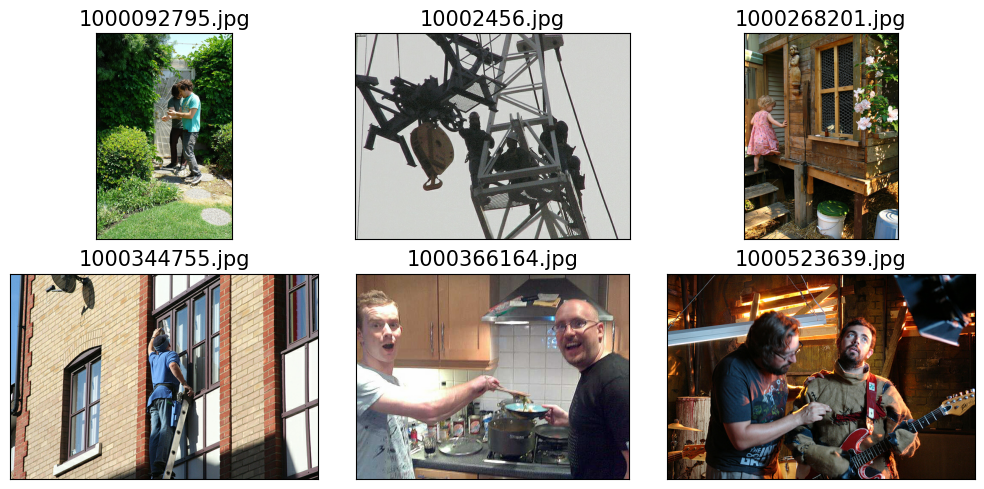

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
fig = plt.figure(figsize=(10, 5))
for i, file in enumerate(file_list[:6]):
  img_raw = tf.io.read_file(file)
  img = tf.image.decode_image(img_raw)
  print('Image shape: ', img.shape)
  ax = fig.add_subplot(2, 3, i+1)
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(img)
  ax.set_title(os.path.basename(file), size=15)
plt.tight_layout()
plt.show()

In [ ]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(mapping):
    # build a list of all description strings
    all_desc = set()
    for key in mapping.keys():
        [all_desc.update(d.split()) for d in mapping[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(mapping)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 17892


In [ ]:
vocab_size=len(vocabulary)+1

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

vgg_model=VGG16(weights='imagenet')
#re-structure the model by removing last 2 layers
vgg_model.layers.pop()
vgg_model=Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
print(vgg_model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
from tqdm.notebook import tqdm
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image

#extract features from image
features={}
#count=0
for img_name in tqdm(file_list):
 #load the images from Images folder
  img_file=cv2.imread(img_name)
  #resize data for model
  img_file=cv2.resize(img_file,(224,224))
  #convert the image pixel to a numpy array
  X=image.img_to_array(img_file)
  #Reshape data for preprocess
  X=X.reshape((1,X.shape[0],X.shape[1],X.shape[2]))

  #preprocess image for feature extraction
  X=preprocess_input(X)
  #get features
  feature=vgg_model.predict(X,verbose=0).reshape(4096,)
  #Get image ID
  image_id=((os.path.basename(img_name)).split('.')[0])

  #Store features
  features[image_id]=feature


  0%|          | 0/31783 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import pickle
pickle.dump(features,open(os.path.join('/content/','features.pk'),'wb'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
with open(os.path.join('/content/drive/MyDrive/','features.pk'),'rb') as f:
  Img_features=pickle.load(f)
len(Img_features)

31783

In [ ]:
from tqdm.notebook import tqdm
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image

#Train test split
image_ids=list(mapping.keys())
split=int(len(image_ids)*0.9)
train_id=image_ids[:split]
print(len(train_id))
#Train_id chunk
train_id_1=train_id[:2500]
train_id_2=train_id[2500:5000]
train_id_3=train_id[5000:]

test_id=image_ids[split:]
print(len(train_id_1),len(train_id_2),len(train_id_3))

28604
2500 2500 23604


In [ ]:
all_captions=[]
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

#Max length of thhe caption available
max_length_cap=max(len(caption.split())for caption in all_captions)
max_length_cap


74

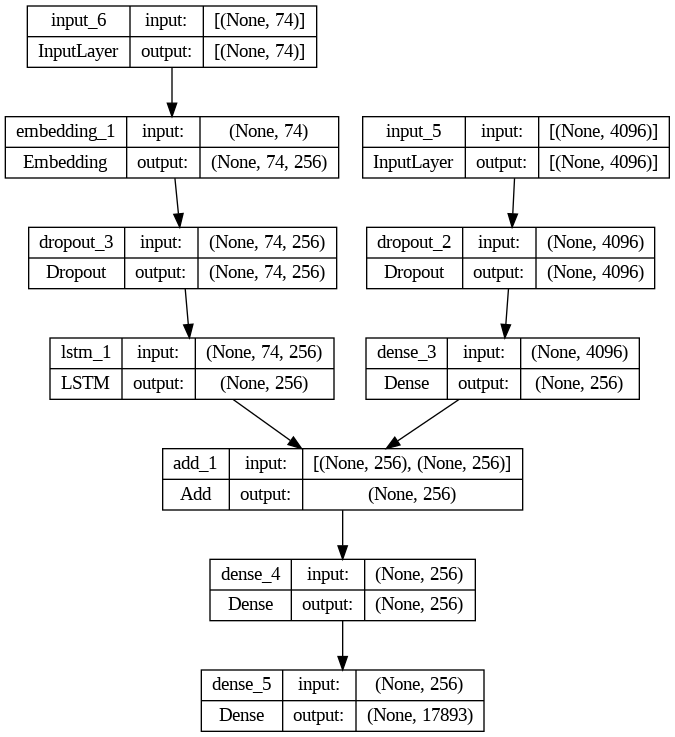

In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout,add
from tensorflow.keras.utils import to_categorical,plot_model
#image Feature layers
inputs1=Input(shape=(4096,))
Features1=Dropout(0.4)(inputs1)
Features2=Dense(256,activation='relu')(Features1)
#Text features layers
inputs2=Input(shape=(max_length_cap,))
seq1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
seq2=Dropout(0.4)(seq1)
seq3=LSTM(256)(seq2)

#Decoder Model
decoder1=add([Features2,seq3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

#plot the model
plot_model(model,show_shapes=True)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def data_generator(data_keys,features,mapping,tokenizer,max_length,vocab_size,batch_size):
  X1,X2,y=[],[],[]
  n=0
  while 1:
    for key in data_keys:
      #print(key)
      n+=1
      captions=mapping[key]
      #print(captions)
      #process each captions
      for caption in captions:
        #encode the sequences
        seq=tokenizer.texts_to_sequences([caption])[0]
        #print(seq)
        #spli sequence into X,y pairs
        for i in range(1,len(seq)):
          #print(seq[i])
          #Split into input and output pairs
          in_seq,out_seq=seq[:i],seq[i]
          #print(in_seq,out_seq)
          #pad input seq
          in_seq=pad_sequences([in_seq],maxlen=max_length)[0]
          #encode output seq
          out_seq=to_categorical([out_seq],num_classes=vocab_size)[0]
          #print(in_seq)
          #print(out_seq)
          #store the seq
          X1.append(features[''.join(key[:-4])])
          X2.append(in_seq)
          y.append(out_seq)
          #print(len(X1),len(X2),len(y))
          #print('X1:',X1)
          #print('X2:',X2)
          #print('y:',y)
      if n==batch_size:
        X1=np.array(X1)
        X2=np.array(X2)
        y=np.array(y)
        #print(X1.shape,X2.shape,y.shape)
        yield [X1,X2],y
        X1,X2,y=[],[],[]
        n=0

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# tokenize the text
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_dict=tokenizer.word_index
#vocab_size=len(vocab_dict)+1 # total number of unique word
vocab_size

17891

In [ ]:
epochs=10
batch_size=64
steps=(len(train_id)//batch_size)
for i in tqdm(range(epochs)):
  print('Epoch: ',i)
  generator=data_generator(train_id,Img_features,mapping,tokenizer,max_length_cap,vocab_size,batch_size)

  model.fit(generator,epochs=1,steps_per_epoch=steps,shuffle=True,verbose=1)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  0
446/446 [==============================] - 452s 1s/step - loss: 4.9085 - accuracy: 0.1912
Epoch:  1
446/446 [==============================] - 440s 986ms/step - loss: 3.9386 - accuracy: 0.2687
Epoch:  2
446/446 [==============================] - 390s 874ms/step - loss: 3.6641 - accuracy: 0.2885
Epoch:  3
 39/446 [=>............................] - ETA: 6:03 - loss: 3.5631 - accuracy: 0.2977

In [ ]:
#import pickle
pickle.dump(model,open(os.path.join('/content/drive/MyDrive/','Model10.pk'),'wb'))

In [ ]:
model.save('/content/drive/MyDrive'+'/Model10.h5')